In [1]:
# Import necessary libraries

import numpy as np
import pandas as pd

import pyspark

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.impute import SimpleImputer


In [2]:
master='local[*]'
spark=(pyspark.sql.SparkSession.builder.master(master).getOrCreate())
spark

In [3]:
# Load the dataset from the local 
PATH_TO_FILE=r"D:\machine_learning_portfolio\supervised_learning\credit_risk_dataset.csv"
#Loading above file to dataframe:
data = spark.read.format("com.databricks.spark.csv") \
  .option("mode", "DROPMALFORMED") \
  .option("header", "true") \
  .option("inferschema", "true") \
  .option("delimiter", ",").load(PATH_TO_FILE)

In [4]:
data.schema

StructType([StructField('person_age', IntegerType(), True), StructField('person_income', IntegerType(), True), StructField('person_home_ownership', StringType(), True), StructField('person_emp_length', DoubleType(), True), StructField('loan_intent', StringType(), True), StructField('loan_grade', StringType(), True), StructField('loan_amnt', IntegerType(), True), StructField('loan_int_rate', DoubleType(), True), StructField('loan_status', IntegerType(), True), StructField('loan_percent_income', DoubleType(), True), StructField('cb_person_default_on_file', StringType(), True), StructField('cb_person_cred_hist_length', IntegerType(), True)])

In [5]:
data.show(6)

+----------+-------------+---------------------+-----------------+-----------+----------+---------+-------------+-----------+-------------------+-------------------------+--------------------------+
|person_age|person_income|person_home_ownership|person_emp_length|loan_intent|loan_grade|loan_amnt|loan_int_rate|loan_status|loan_percent_income|cb_person_default_on_file|cb_person_cred_hist_length|
+----------+-------------+---------------------+-----------------+-----------+----------+---------+-------------+-----------+-------------------+-------------------------+--------------------------+
|        22|        59000|                 RENT|            123.0|   PERSONAL|         D|    35000|        16.02|          1|               0.59|                        Y|                         3|
|        21|         9600|                  OWN|              5.0|  EDUCATION|         B|     1000|        11.14|          0|                0.1|                        N|                         2|
|    

##### The features (columns) in the dataset:

*person_age*: Represents the age of the individual applying for the loan.

*person_income*: Denotes the annual income of the person.

*person_home_ownership*: Indicates the type of home ownership (e.g., rent, mortgage, own).

*person_emp_length*: Reflects the length of employment in years.

*loan_intent*: Describes the purpose or intent of the loan (e.g., debt consolidation, home improvement, education).

*loan_grade*: Represents the assigned grade or risk level of the loan.

*loan_amnt*: Specifies the loan amount requested.

*loan_int_rate*: Refers to the interest rate associated with the loan.

*loan_status*: Indicates the loan status (0 for non-default, 1 for default).

*loan_percent_income*: Represents the percentage of income allocated to the loan.

*cb_person_default_on_file*: Captures historical default information (whether the person has defaulted on a loan previously).

*cb_preson_cred_hist_length*: Reflects the length of the person’s credit history.

Exploratory Data Analysis (EDA): Unveiling Insights from Data

**Introduction**
    Exploratory Data Analysis (EDA) plays a pivotal role. Before embarking on any sophisticated modeling or predictive tasks, it is crucial to grasp the essence of the data at hand. EDA allows us to delve into the data, uncover hidden patterns, and gain valuable insights. In this article, we’ll explore the fundamental steps of EDA and understand why it’s an indispensable part of any data-driven project.

**What Is EDA?**
    EDA is the process of examining and visualizing data to comprehend its structure, relationships, and underlying characteristics. By scrutinizing the data, we can identify outliers, missing values, correlations, and potential pitfalls. EDA sets the stage for subsequent analyses, guiding us toward informed decisions.

*Data Summary:*
    Get an overview of the dataset: dimensions, column names, data types, and basic statistics.
    Use tools like .info(), .describe(), and .head() to explore the data.

*Handling Missing Values*:
    Identify missing values (NaNs) and decide how to handle them (imputation, removal, or other strategies).

*Exploring Individual Features*:
    Visualize distributions of numerical features (histograms, box plots, etc.).
    Explore categorical features using bar charts or count plots.

*Correlation Analysis*:
    Compute correlation coefficients (e.g., Pearson, Spearman) between numerical features.
    Visualize correlations using heatmaps.

*Outlier Detection*:
    Detect outliers using statistical methods (e.g., z-scores, IQR).
    Visualize outliers with scatter plots or box plots.

*Feature Relationships*:
    Investigate relationships between pairs of features (scatter plots, pair plots).
    Look for linear or nonlinear associations.

*Feature Engineering Ideas*:
    Based on insights from EDA, brainstorm feature engineering possibilities.
    Create new features or transform existing ones.

EDA is not a one-size-fits-all process; it adapts to the specific dataset and problem domain. By investing time in thorough exploration, data scientists can make informed decisions, build robust models, and extract meaningful knowledge from their data. So, before diving into complex algorithms, remember to explore, visualize, and gain insights—the EDA way!

Rows (Observations): These are the individual data points. For instance, if we're analyzing customer data, each row might represent a customer.

Columns (Features): These are the attributes or characteristics associated with each observation. Examples include age, income, product ratings, etc.
To find out the shape of your DataFrame (or any other data structure), use the .shape attribute. It will give us the total number of rows and columns. 

Data comes in various flavors: numeric, categorical, text, dates, and more. The data types of the columns determine how you can manipulate and analyze them. For instance, we wouldn’t perform mathematical operations on a text column.

To explore the data types of the DataFrame, use the .dtypes attribute. From that we can know what column is included with what data types. Understanding the data types helps us choose appropriate visualization techniques, handle missing values, and prepare for modeling.

In [6]:
print("\nSummary statistics:\n")
data.describe().show()


Summary statistics:

+-------+-----------------+-----------------+---------------------+-----------------+-----------------+----------+-----------------+------------------+-------------------+-------------------+-------------------------+--------------------------+
|summary|       person_age|    person_income|person_home_ownership|person_emp_length|      loan_intent|loan_grade|        loan_amnt|     loan_int_rate|        loan_status|loan_percent_income|cb_person_default_on_file|cb_person_cred_hist_length|
+-------+-----------------+-----------------+---------------------+-----------------+-----------------+----------+-----------------+------------------+-------------------+-------------------+-------------------------+--------------------------+
|  count|            32581|            32581|                32581|            31686|            32581|     32581|            32581|             29465|              32581|              32581|                    32581|                     32581

In [7]:
data.summary().show()

+-------+-----------------+-----------------+---------------------+-----------------+-----------------+----------+-----------------+------------------+-------------------+-------------------+-------------------------+--------------------------+
|summary|       person_age|    person_income|person_home_ownership|person_emp_length|      loan_intent|loan_grade|        loan_amnt|     loan_int_rate|        loan_status|loan_percent_income|cb_person_default_on_file|cb_person_cred_hist_length|
+-------+-----------------+-----------------+---------------------+-----------------+-----------------+----------+-----------------+------------------+-------------------+-------------------+-------------------------+--------------------------+
|  count|            32581|            32581|                32581|            31686|            32581|     32581|            32581|             29465|              32581|              32581|                    32581|                     32581|
|   mean|27.73459992

The break down the summary statistics for the given dataset:

person_age:
The average age of individuals in the dataset is approximately 27.7 years.
The youngest person is 20 years old, and the oldest person is 144 years old.

person_income:
The average annual income is approximately $66,074.
The minimum income recorded is $4,000, and the maximum income is $6,000,000.

person_emp_length:
The average employment length is approximately 4.8 years.
The minimum employment length is 0 years, and the maximum is 123 years (which seems unusual).

loan_amnt:
The average loan amount requested is approximately $9,589.
The smallest loan requested is $500, and the largest is $35,000.

loan_int_rate:
The average interest rate on loans is approximately 11.01%.
The lowest interest rate is 5.42%, and the highest is 23.22%.

loan_status:
The dataset contains both non-default (0) and default (1) loan statuses.
Approximately 21.8% of loans are in default.

loan_percent_income:
On average, loans represent 17.02% of an individual’s income.
The loan-to-income ratio ranges from 0% to 83%.

cb_person_cred_hist_length:
The average credit history length is approximately 5.8 years.
The shortest credit history is 3 years, and the longest is 30 years.

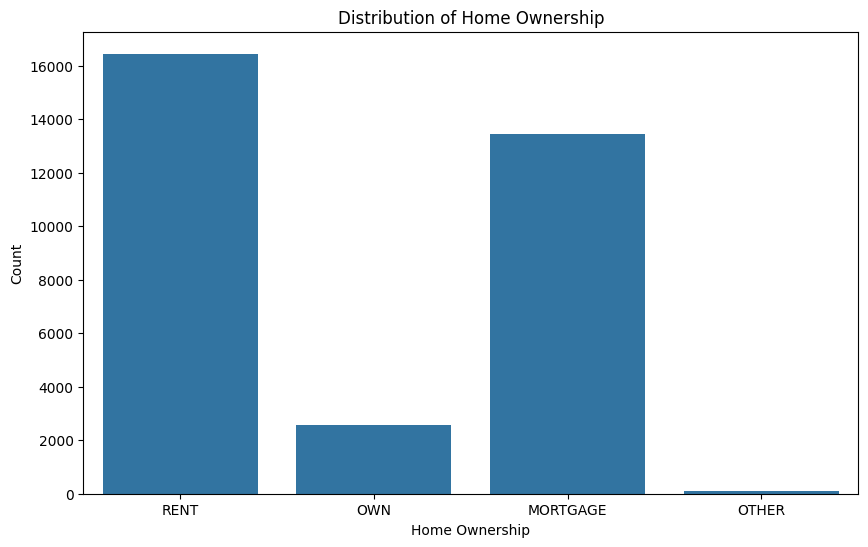

In [8]:
#Explore relationships between variables using visualizations.
pandas_df = data.toPandas()
plt.figure(figsize=(10, 6))
sns.countplot(x='person_home_ownership', data=pandas_df)
plt.xlabel("Home Ownership")
plt.ylabel("Count")
plt.title("Distribution of Home Ownership")
plt.show()


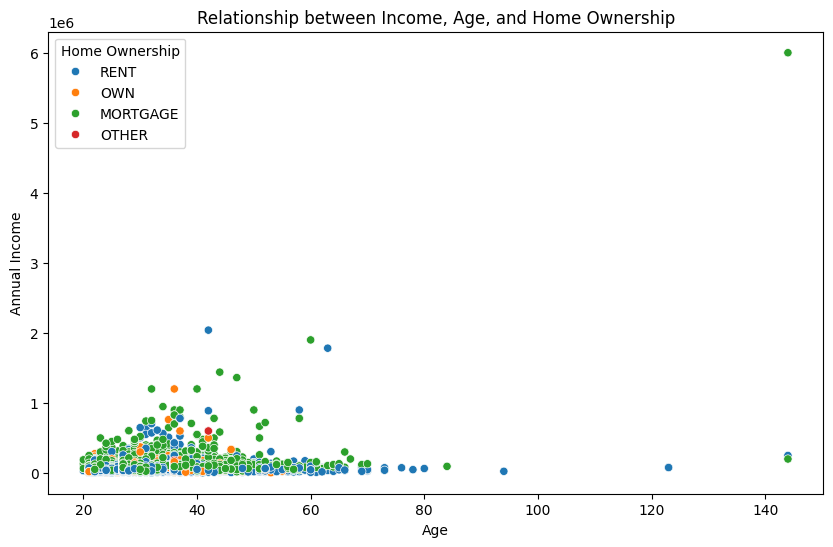

In [9]:
# Create a scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='person_age', y='person_income', hue='person_home_ownership', data=pandas_df)
plt.xlabel("Age")
plt.ylabel("Annual Income")
plt.title("Relationship between Income, Age, and Home Ownership")
plt.legend(title="Home Ownership")
plt.show()

In [10]:
# print("\nMissing values:\n", data.isnull().sum())
# Handle missing data as needed
#  Example: Impute missing values with mean or median
# data['person_income'].fillna(data['person_income'].median(), inplace=True)

from pyspark.sql.functions import col

# Calculate missing values count for each column
missing_values = data.select([col(c).alias(c) for c in data.columns]).na.drop().count()

# Print missing values count for each column
print("\nMissing values:\n")
for col_name in data.columns:
    missing_count = data.filter(col(col_name).isNull()).count()
    print(f"{col_name}: {missing_count} missing values")

# Handle missing data (impute with median income)
median_income = data.selectExpr("percentile_approx(person_income, 0.5)").collect()[0][0]
data = data.fillna(median_income, subset=["person_income"])

# Print success message
print("\nMissing values imputed with median income.")



Missing values:

person_age: 0 missing values
person_income: 0 missing values
person_home_ownership: 0 missing values
person_emp_length: 895 missing values
loan_intent: 0 missing values
loan_grade: 0 missing values
loan_amnt: 0 missing values
loan_int_rate: 3116 missing values
loan_status: 0 missing values
loan_percent_income: 0 missing values
cb_person_default_on_file: 0 missing values
cb_person_cred_hist_length: 0 missing values

Missing values imputed with median income.


In [22]:
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline

# Drop rows with missing values (for simplicity)
df_cleaned = data.dropna()

# Convert categorical columns to numerical using StringIndexer
categorical_columns = ["person_home_ownership", "loan_intent", "loan_grade", "cb_person_default_on_file"]
indexers = [StringIndexer(inputCol=col, outputCol=col + "_index").fit(df_cleaned) for col in categorical_columns]

# Assemble features into a vector
feature_columns = ["person_age", "person_income", "person_emp_length", "loan_amnt", "loan_int_rate", "loan_percent_income", "cb_person_cred_hist_length"]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

# Create a RandomForestRegressor
rf = RandomForestRegressor(featuresCol="features", labelCol="loan_status", numTrees=100)

# Create a pipeline
pipeline = Pipeline(stages=indexers + [assembler, rf])

# Split data into training and testing sets
train_data, test_data = df_cleaned.randomSplit([0.8, 0.2], seed=42)

try:
    # Fit the pipeline to the training data
    model = pipeline.fit(train_data)

    # Make predictions on the test data
    predictions = model.transform(test_data)

    # Evaluate the model
    evaluator = RegressionEvaluator(labelCol="loan_status", predictionCol="prediction", metricName="rmse")
    rmse = evaluator.evaluate(predictions)
    print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

    # Print feature importances
    feature_importances = model.stages[-1].featureImportances
    print("\nFeature Importances:")
    for i, col in enumerate(feature_columns):
        print(f"{col}: {feature_importances[i]:.4f}")

except Exception as e:
    print(f"Error: {str(e)}")


Root Mean Squared Error (RMSE): 0.32

Feature Importances:
person_age: 0.0024
person_income: 0.1681
person_emp_length: 0.0263
loan_amnt: 0.0425
loan_int_rate: 0.3104
loan_percent_income: 0.4482
cb_person_cred_hist_length: 0.0021
